In [5]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import time
import matplotlib.dates as mdates
%matplotlib notebook
%matplotlib inline
plt.style.use('seaborn')
sns.set_palette("muted")

In [3]:
filePath = 'data/july-2017-thru-june-2018.txt'

In [4]:
accre_data = pd.read_csv(filePath, delimiter='|',dtype='str')

## Q1: What is the relationship between queue time and (a) amount of memory requested, (b) amount of computing time requested? (Glenna)

### Restrict data to just jobs run from the production queue

In [6]:
accre_data = accre_data.loc[accre_data.Partition == 'production']

### Recast date/time columns as datetime format

In [7]:
accre_data.Submit = pd.to_datetime(accre_data.Submit)
accre_data.Start = pd.to_datetime(accre_data.Start)

### Calculate WaitTime and assign to new column

In [8]:
accre_data['WaitTime'] = accre_data.Start - accre_data.Submit

### Strip off the last two characters of ReqMem and pass to new columns

In [9]:
accre_data['NorC'] = accre_data.ReqMem.str[-1]
accre_data['MemUnits'] = accre_data.ReqMem.str[-2]
accre_data['ReqMemInBytes'] = accre_data.ReqMem.str[:-2]
accre_data['ReqMemInBytes'] = pd.to_numeric(accre_data.ReqMemInBytes, errors='ignore')
#accre_data.MemUnits.value_counts()

M    7866493
G    4434926
Name: MemUnits, dtype: int64

In [10]:
accre_data.NNodes = pd.to_numeric(accre_data.NNodes, errors = 'ignore')
accre_data.NCPUS = pd.to_numeric(accre_data.NCPUS, errors = 'ignore')

### Convert ReqMem to useable units (bytes)

In [11]:
mask = (accre_data.NorC == 'n')
accre_data.loc[mask,'ReqMemInBytes'] = accre_data.loc[mask,'ReqMemInBytes']*accre_data.loc[mask,'NNodes']
accre_data.loc[~mask,'ReqMemInBytes'] = accre_data.loc[~mask,'ReqMemInBytes']*accre_data.loc[~mask,'NCPUS']
maskG = (accre_data.MemUnits == 'G')
accre_data.loc[maskG,'ReqMemInBytes'] = accre_data.loc[maskG,'ReqMemInBytes']*(10.**9.)
maskM = (accre_data.MemUnits == 'M')
accre_data.loc[maskM,'ReqMemInBytes'] = accre_data.loc[maskM,'ReqMemInBytes']*(10.**6.)

### Reformat the Timelimit series

In [12]:
accre_data['ReqD'] = pd.to_numeric(accre_data.Timelimit.str[:-9]).fillna(value=0)*24. # in units of hours
accre_data['ReqHMS'] = pd.to_timedelta(accre_data.Timelimit.str[-7::]).astype('timedelta64[s]')/(3600.) # in units of hours

In [11]:
#accre_data.WaitTime.astype('timedelta64[s]').head()

0    91981.0
1    92350.0
2    93615.0
3    94255.0
4        1.0
Name: WaitTime, dtype: float64

### Is there a relationship between the amount of computing time requested by a user and the queue time?

[]

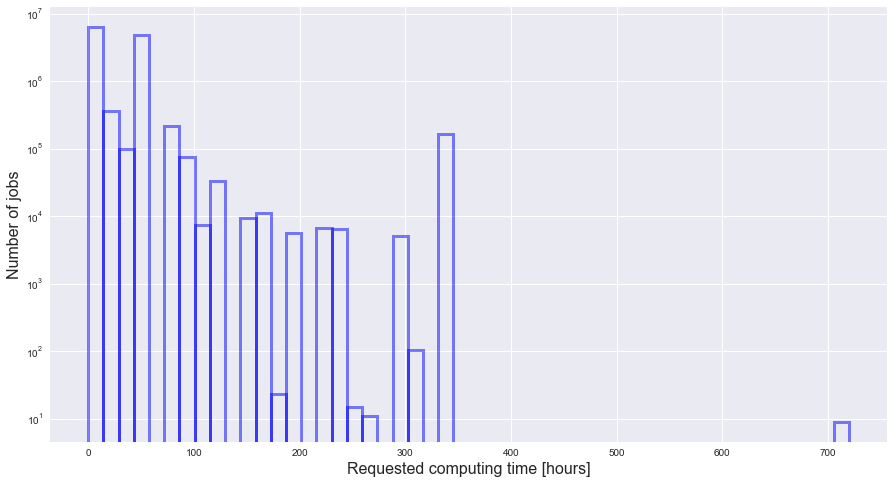

In [18]:
plt.figure(figsize=(15,8))
sns.distplot(accre_data.ReqD+accre_data.ReqHMS,kde=False,bins=50,hist_kws={"histtype": "bar", "linewidth": 3,"alpha": 0.5, "edgecolor": "blue", "facecolor": "None"})
plt.xlabel('Requested computing time [hours]',fontsize=16)
plt.ylabel('Number of jobs',fontsize=16)
plt.semilogy()

In [ ]:
plt.figure(figsize=(15,8))
sns.scatterplot(x=accre_data.ReqD+accre_data.ReqHMS,y=accre_data.WaitTime.astype('timedelta64[s]')/3600.,data=accre_data,palette='muted',edgecolor='b',facecolor='None')
#plt.semilogx()
#plt.semilogy()
plt.xlabel('Requested Computing Time [Hours]',fontsize=16)
plt.ylabel('Wait Time [Hours]',fontsize=16)

Text(0,0.5,'Wait Time [Hours]')

### Now let's consider a single group of users that have the same fairshare.  CMS submitted the most jobs in this dataset.

In [ ]:
plt.figure(figsize=(15,8))
subset = accre_data.loc[accre_data.Group=='cms']
sns.scatterplot(x=subset.ReqD+subset.ReqHMS,y=subset.WaitTime.astype('timedelta64[s]')/3600.,s=subset.ReqMemInBytes)
#plt.semilogy()
plt.xlabel('Requested Computing Time [Hours]',fontsize=16)
plt.ylabel('Wait Time [Hours]',fontsize=16)

Text(0,0.5,'Wait Time [Hours]')

## Does a relationship exist between the amount of memory requested by a user and their wait time in the queue?

[]

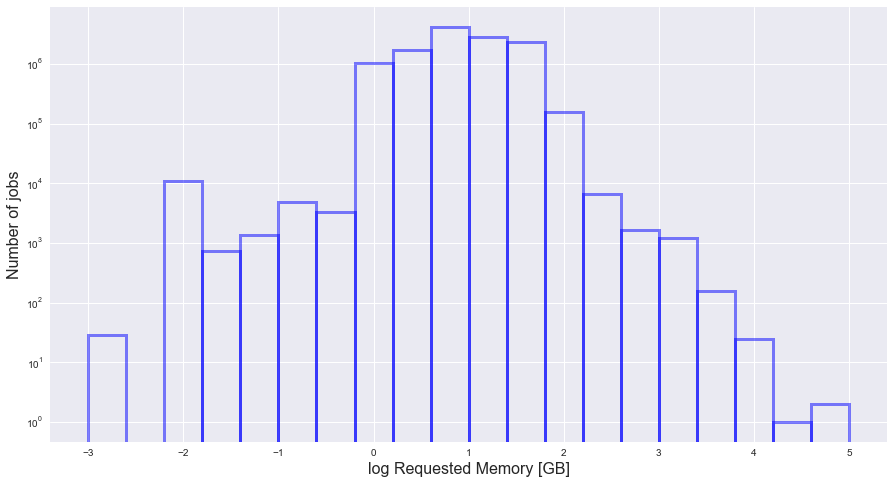

In [14]:
plt.figure(figsize=(15,8))
sns.distplot(np.log10(accre_data.ReqMemInBytes.dropna()/(10.**9)), kde=False, bins=20, hist_kws={"histtype": "bar", "linewidth": 3,"alpha": 0.5, "edgecolor": "blue", "facecolor": "None"})
plt.xlabel('log Requested Memory [GB]',fontsize=16)
plt.ylabel('Number of jobs',fontsize=16)
plt.semilogy()

TypeError: ufunc 'sqrt' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

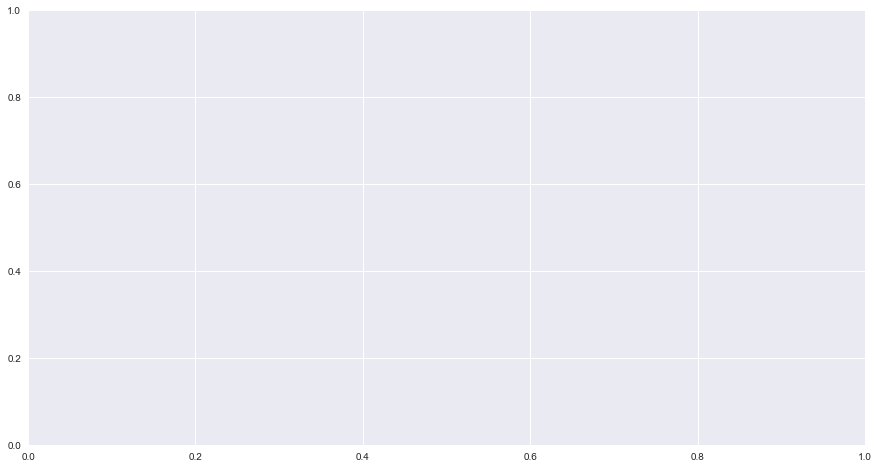

In [16]:
plt.figure(figsize=(15,8))
plt.scatter(accre_data.ReqMemInBytes/(10.**9.),accre_data.WaitTime.astype('timedelta64[s]')/3600.,'.')
plt.semilogx()
plt.xlabel('Requested Memory [GB]',fontsize=16)
plt.ylabel('Wait Time [Hour]',fontsize=16)

### Let's look at a single group, which all have the same fair-share rank.  The CMS group submits the most jobs.

Text(0,0.5,'Wait Time [Hour]')

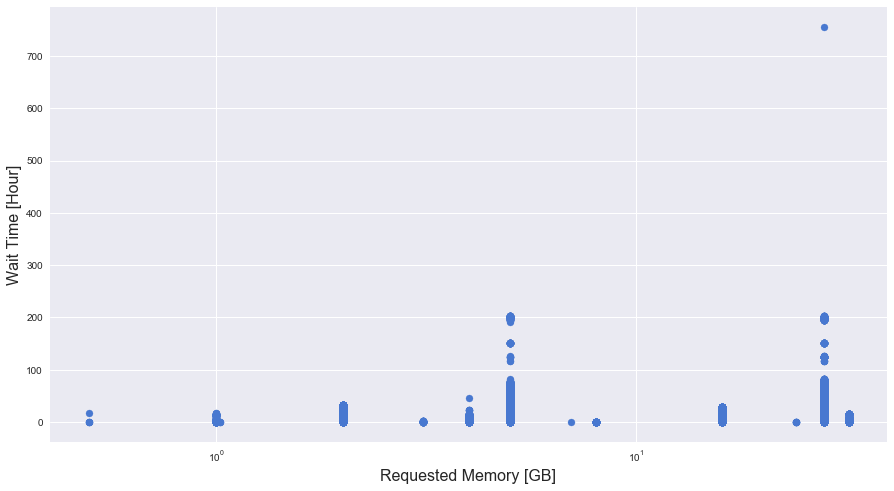

In [17]:
plt.figure(figsize=(15,8))
subset = accre_data.loc[accre_data.Group=='cms']
plt.scatter(subset.ReqMemInBytes/(10.**9.),subset.WaitTime.astype('timedelta64[s]')/3600.)
plt.semilogx()
plt.xlabel('Requested Memory [GB]',fontsize=16)
plt.ylabel('Wait Time [Hour]',fontsize=16)

### Let's subset this further by looking at a time when the queue is busy.

In [202]:
#subset.sort_values('Submit', inplace=True)
#subset = subset.groupby('User').rolling('14400s', on='Submit').JobIDRaw.count()
#subset.head()

In [203]:
#subset = accre_data.loc[accre_data.NCPUS == 1]
#plt.scatter(subset.ReqMemInBytes/(10.**9.),subset.WaitTime.astype('timedelta64[s]')/3600.,label=r'$N_{\rm CPUs} = 1$')
#plt.semilogx()
#plt.semilogy()
#plt.legend()
#plt.ylim(0.1,1000.)
#plt.xlabel('Requested Memory [GB]')
#plt.ylabel('Wait Time [Hour]')

In [204]:
#subset = accre_data.loc[accre_data.NCPUS == 2]
#plt.scatter(subset.ReqMemInBytes/(10.**9.),subset.WaitTime.astype('timedelta64[s]')/3600.,label=r'$N_{\rm CPUs} = 2$')
#plt.semilogx()
#plt.semilogy()
#plt.legend()
#plt.ylim(0.1,1000.)
#plt.xlabel('Requested Memory [GB]')
#plt.ylabel('Wait Time [Hour]')

In [205]:
#subset = accre_data.loc[accre_data.NCPUS == 8]
#plt.scatter(subset.ReqMemInBytes/(10.**9.),subset.WaitTime.astype('timedelta64[s]')/3600.,label=r'$N_{\rm CPUs} = 8$')
#plt.semilogx()
#plt.semilogy()
#plt.legend()
#plt.ylim(0.1,1000.)
#plt.xlabel('Requested Memory [GB]')
#plt.ylabel('Wait Time [Hour]')

In [206]:
#subset = accre_data.loc[accre_data.NCPUS > 8]
#plt.scatter(subset.ReqMemInBytes/(10.**6.),subset.WaitTime.astype('timedelta64[s]')/3600.,label=r'$N_{\rm CPUs} > 8$')
#plt.semilogx()
#plt.semilogy()
#plt.legend()
#plt.ylim(0.1,1000.)
#plt.xlabel('Requested Memory [MB]')
#plt.ylabel('Wait Time [Hour]')

In [207]:
#subset = accre_data.loc[accre_data.NNodes > 1]
#plt.scatter(subset.ReqMemInBytes/(10.**6.),subset.WaitTime.astype('timedelta64[s]')/3600.,label=r'$N_{\rm nodes} > 1$')
#plt.semilogx()
#plt.semilogy()
#plt.legend()
##plt.ylim(0.1,1000.)
#plt.xlabel('Requested Memory [MB]')
#plt.ylabel('Wait Time [Hour]')

## Does a relationship exist between the number of CPUs requested by a user and their wait time in the queue?

[]

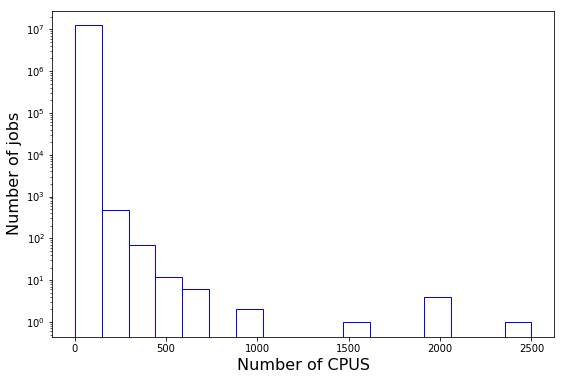

In [69]:
plt.figure(figsize=(15,8))
plt.hist(accre_data.NCPUS,bins=17,histtype='bar',fill=False,edgecolor='blue')
plt.xlabel('Number of CPUS',fontsize=16)
plt.ylabel('Number of jobs',fontsize=16)
plt.semilogy()

Text(0,0.5,'Wait Time [Hour]')

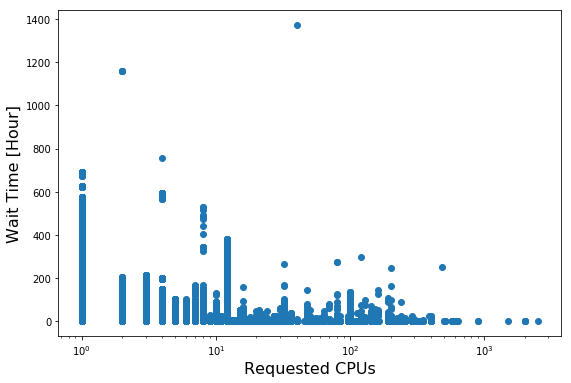

In [68]:
plt.figure(figsize=(15,8))
#print(accre_data.WaitTime)
#accre_data.WaitTime = pd.to_numeric(accre_data.WaitTime)
#print(accre_data.WaitTime)
plt.scatter(accre_data.NCPUS,accre_data.WaitTime.astype('timedelta64[s]')/3600.)
plt.semilogx()
#sns.kdeplot(accre_data.NCPUS,accre_data.WaitTime.astype('timedelta64[s]')/3600.)
#plt.semilogy()
#plt.legend()
#plt.ylim(0.1,1000.)
plt.xlabel('Requested CPUs',fontsize=16)
plt.ylabel('Wait Time [Hour]',fontsize=16)

## Common lore in my department is that your jobs will experience a shorter queue time if you submit them at 3 AM.  Is this true?  Is there a relationship between the time of day of job submission and wait time in the queue?

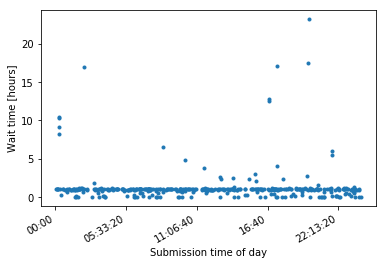

In [81]:
plt.figure(figsize=(15,8))
fig,ax = plt.subplots()
ax.plot(subset.Submit.dt.time,subset.WaitTime.astype('timedelta64[s]')/3600.,'.')
ax.set_ylabel('Wait time [hours]')
ax.set_xlabel('Submission time of day')
fig.autofmt_xdate(rotation=30)

#### Possible future work: Can we parameterize a user's efficiency?  Elapsed time/wait time? What if wait time is 0 seconds?  make a floor of 1 second of wait time?  If I wait 5 seconds to launch a 14 day job, I'm efficient.  If I wait 24 hours to submit a job that runs for less than a minute, maybe I should reconsider my life choices.  Calculate for each job and then give each user an average rating?

## Q2: Identify problem nodes that have an above-average fail rate. (Chris)

### Before we answer that question, we will only consider jobs that used 1 node (which is about 91% of all jobs).

In [ ]:
accre_data['NNodes'].value_counts()

In [ ]:
One_Node= accre_data[accre_data['NNodes'] == 1]

### Let's look at the failure rate of the most used node--vmp1409--before we look at all nodes.

In [ ]:
accre_data[(accre_data['State'] == "NODE_FAIL") & (accre_data["NodeList"] == "vmp1409")]

In [ ]:
print(len(accre_data[accre_data["NodeList"]=="vmp1409"]))

In [ ]:
len(accre_data[(accre_data['State'] == "NODE_FAIL") & (accre_data["NodeList"] == "vmp1409")])

In [ ]:
len(accre_data[(accre_data['State'] == "NODE_FAIL") & (accre_data["NodeList"] == "vmp1409")])/len(accre_data[accre_data["NodeList"]=="vmp1409"])

### Node vmp1409 was used to execute 92,419 jobs. It had 1 node failure. The frequency of failure was basically 0% (YAY!).

### Let's create a separate dataframe that calculates node failure for each node.

In [ ]:
bad_nodes = accre_data.loc[(accre_data['State']=='NODE_FAIL') & (accre_data['NNodes']==1)]

In [ ]:
node_df= pd.DataFrame(accre_data.NodeList.value_counts(ascending=False)).reset_index()
node_df = node_df.rename(index = str, columns = {'index': 'Node Code', 'NodeList': 'Total Jobs'})

In [ ]:
node_failure_df = pd.DataFrame(bad_nodes.NodeList.value_counts(ascending=False)).reset_index()
node_failure_df = node_failure_df.rename(index = str, columns = {'index' : 'Node Code', 'NodeList': 'Failed Jobs'})

In [ ]:
combined_df = pd.merge(node_df, node_failure_df, on ="Node Code", how = "inner")

In [ ]:
combined_df['Frequency'] = combined_df['Failed Jobs']/combined_df['Total Jobs']

In [ ]:
combined_df.sort_values(by=['Frequency'], ascending=False)

### Forunately, the most commonly used node (vmp 1409) had the lowest failure rate.

In [ ]:
combined_df['Frequency'].mean()

### The mean node failure rate is about .07%.

In [ ]:
combined_df['Frequency'].median()

### The median failure rate is about 0.03%.

In [ ]:
combined_df["Frequency"].std()

### One standard deviation is about 0.7%.

### Let's look at the distribution of failure rates with a histogram.

In [ ]:
combined_df.hist(column='Frequency', bins=100, grid=False, figsize=(16,12), color='#86bf91', zorder=2, rwidth=0.5,)
plt.xlabel("Rate of Failure 0.1 = 10%", fontsize=16)
plt.semilogx()
plt.semilogy()
plt.title("Failure Rate Histogram",fontsize=16)
plt.ylabel("Frequency of Failure",fontsize=16)

In [ ]:
combined_df["Frequency"].plot(kind='box', figsize=(6,10))
plt.semilogy()
plt.xlabel("Frequency of Failure",fontsize=16)

### The boxplot and histogram shows the data is skewed right b/c of some high frequency node failure outliers. Let's figure out exactly which nodes have these high failure rates, and determine how they compare to the median.

In [ ]:
q = [0.25, 0.75]
combined_df["Frequency"].quantile(q)

### Depending on how we define an "outlier," any node with a failure rate above the 75% percentile (0.05% fail rate) we may consider to have a disproportionately high fail rate.

In [ ]:
combined_df.nlargest(5, "Frequency")

### Node vm-qa-node004 has the highest failure rate, about 17%. This is more than 24 standard deviations from the mean. We can safely say that this a "bad node" because it is such an extreme outlier. It should be pointed out that it was only used for 6 total jobs--so this high fail rate may not necessarily be relevant.

### The next highest frequency of failures were as follows: Node vmp595 has a 0.79% failure rate, node vmp598 has a 0.67% failure rate, node vmp592 has a 0.65% failure rate, and node vmp692 has a 0.62% failure rate. We can safely consider the top 5 node failure rates outliers because they well outside the inner-quartile range--which has about an 0.05% failure rate cut at the 75th percentile.

### Let's focus in on the top quartile (149 nodes) to see if the distribution of failure rates looks different from the general dataset.

In [ ]:
subset_filter = combined_df.loc[combined_df['Frequency']>= combined_df["Frequency"].quantile(0.75)]

In [ ]:
subset_filter.nlargest(5, "Frequency")

In [ ]:
subset_filter["Frequency"].plot(kind='box',figsize=(6,8))
plt.semilogy()
plt.xlabel('Top Quartile Failure Relative Comparison', fontsize=16)

In [ ]:
subset_filter.hist(column='Frequency', bins=100, grid=False, figsize=(16,12), color='#86bf91', zorder=2, rwidth=0.5,)
plt.xlabel("Rate of Failure 0.1 = 10%", fontsize=16)
plt.semilogx()
plt.semilogy()
plt.ylabel("Frequency of Failure", fontsize=16)
plt.title("Frequency of Failure Histogram for the Top Quartile", fontsize=16)

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.regplot(x= "Total Jobs", y = "Failed Jobs", data=subset_filter)
plt.xlabel('Top Quartile Total Jobs', fontsize=16)
plt.ylabel('Top Quartile Failed Jobs', fontsize=16)

In [ ]:
subset_filter['Frequency'].median()

### This boxplot and the historgram tell us that most data in the top quartile has a failure rate of around 0.07% (less than a tenth of a percent). This explains why the histogram is unimodal. AKA the spread is relatively tight, even among the top quartile. There are handful of nodes outside of the 75th percentile within the top quartile that buck this trend (aks above the 94th percentile). Thus, we will safely consider any node above the 94th percentile a "bad node," as opposed to all nodes in the top quartile.

## Q3: Identify problem users who submit more than 500 jobs that run for less than 5 minutes in a four hour window.  (UrLeaka)

In [ ]:
accre_data['RunCalc'] = accre_data.End - accre_data.Start

In [ ]:
days=accre_data.RunCalc.dt.days

In [ ]:
completed=accre_data[accre_data.State == 'COMPLETED']
completed['days']=days
less24hrs = completed[completed.days< 1]

In [ ]:
secs_RunCalc=less24hrs.RunCalc.dt.seconds
less24hrs['secs_RunCalc'] = secs_RunCalc

In [ ]:
secs_RunCalc300s = less24hrs[less24hrs.secs_RunCalc<=300]

In [ ]:
prob_jobs=secs_RunCalc300s

#### Out of 100 cases selected in intial download, 74 cases may be problematic due to short run time.  Narrow down jobs within 4 hours later...

In [ ]:
prob_users=prob_jobs.User.value_counts()

In [ ]:
pu1=prob_users>50
pu2=pu1.to_dict()

In [ ]:
prob_jobs['greater500']=prob_jobs['User'].map(pu2)